In [1]:
!pip install tensorflow
!pip install keras

In [2]:
!pip install spotipy

In [20]:
!pip install requests

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

#Libraries to create the multiclass model
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
#Import tensorflow and disable the v2 behavior and eager mode
import tensorflow as tf
#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.disable_v2_behavior()

#Library to validate the model
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score

In [3]:
import spotipy
import time
from IPython.core.display import clear_output
from spotipy import SpotifyClientCredentials, util

import requests

In [4]:
df = pd.read_csv("sample_dataset.csv")
df.head()

,name,album,artist,id,release_date,popularity,length,danceability,acousticness,energy,instrumentalness,liveness,valence,loudness,speechiness,tempo,key,time_signature,mood
0,1999,1999,Prince,2H7PHVdQ3mXqEHXcvclTB0,1982-10-27,68,379266,0.866,0.13700,0.730,0.000000,0.0843,0.625,-8.201,0.0767,118.523,5,4,Happy
1,23,23,Blonde Redhead,4HIwL9ii9CcXpTOTzMq0MP,2007-04-16,43,318800,0.381,0.01890,0.832,0.196000,0.1530,0.166,-5.069,0.0492,120.255,8,4,Sad
2,9 Crimes,9,Damien Rice,5GZEeowhvSieFDiR8fQ2im,2006-11-06,60,217946,0.346,0.91300,0.139,0.000077,0.0934,0.116,-15.326,0.0321,136.168,0,4,Sad
3,99 Luftballons,99 Luftballons,Nena,6HA97v4wEGQ5TUClRM0XLc,1984-08-21,2,233000,0.466,0.08900,0.438,0.000006,0.1130,0.587,-12.858,0.0608,193.100,4,4,Happy
4,A Boy Brushed Red Living In Black And White,They're Only Chasing Safety,Underoath,47IWLfIKOKhFnz1FUEUIkE,2004-01-01,60,268000,0.419,0.00171,0.932,0.000000,0.1370,0.445,-3.604,0.1060,169.881,1,4,Energetic


In [5]:
col_features = df.columns[6:-3]
X= MinMaxScaler().fit_transform(df[col_features])
X2 = np.array(df[col_features])
Y_labels = df['mood']

In [6]:
Y_labels.head()

0        Happy
1          Sad
2          Sad
3        Happy
4    Energetic
Name: mood, dtype: object

In [7]:
encoder = LabelEncoder()
encoder.fit(Y_labels)
encoded_y = encoder.transform(Y_labels)


#Convert to  dummy (Not necessary in my case)
dummy_y = np_utils.to_categorical(encoded_y)

X_train,X_test,Y_train,Y_test = train_test_split(X,encoded_y,test_size=0.2,random_state=15)

target = pd.DataFrame({'mood':df['mood'].tolist(),'encode':encoded_y}).drop_duplicates().sort_values(['encode'],ascending=True)
target

,mood,encode
5,Calm,0
4,Energetic,1
0,Happy,2
1,Sad,3


In [17]:
def initialize_nn():
    #Create the model
    model = Sequential()
    #Add 1 layer with 8 nodes,input of 4 dim with relu function
    model.add(Dense(8,input_dim=10,activation='relu'))
    #Add 1 layer with output 3 and softmax function
    model.add(Dense(4,activation='softmax'))
    #Compile the model using sigmoid loss function and adam optim
    model.compile(loss='categorical_crossentropy',optimizer='adam',
                 metrics=['accuracy'])
    return model

model = initialize_nn()

In [9]:
estimator = KerasClassifier(build_fn=initialize_nn,epochs=300,batch_size=200,verbose=0)

estimator.fit(X_train,Y_train)

In [19]:
estimator.model.save("test_model.h5")

In [12]:
y_preds = estimator.predict(X_test)

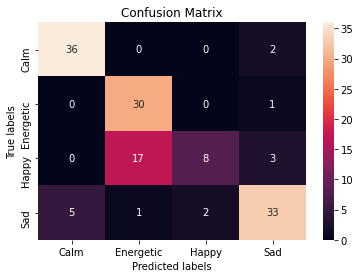

Accuracy Score 0.7753623188405797


In [13]:
cm = confusion_matrix(Y_test,y_preds)
ax = plt.subplot()
sns.heatmap(cm,annot=True,ax=ax)

labels = target['mood']
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

print("Accuracy Score",accuracy_score(Y_test,y_preds))

In [16]:
#need to figure out way to save trained model
# saving model
json_model = estimator.model.to_json()
open('model_architecture.json', 'w').write(json_model)
# saving weights
estimator.save_weights('model_weights.h5', overwrite=True)

AttributeError: 'KerasClassifier' object has no attribute 'save_weights'

In [28]:
def predict_mood(id_song):
    #Join the model and the scaler in a Pipeline
    pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=initialize_nn,epochs=300,
                                                                             batch_size=200,verbose=0))])
    #Fit the Pipeline
    pip.fit(X2,encoded_y)

    #Obtain the features of the song
    preds = getSong(id_song)
    #Pre-process the features to input the Model
    preds_features = np.array(preds[0][6:-2]).reshape(-1,1).T

    #Predict the features of the song
    results = pip.predict(preds_features)

    mood = np.array(target['mood'][target['encode']==int(results)])
    name_song = preds[0][0]
    artist = preds[0][2]

    return print("{0} by {1} is a {2} song".format(name_song,artist,mood[0].upper()))
    #print(f"{name_song} by {artist} is a {mood[0].upper()} song")

In [15]:
from sagemaker import get_execution_role
from sagemaker import Session
role = get_execution_role()
sess = Session()
bucket = sess.default_bucket()

In [16]:
client_id='50b04075d9a54b24aafd6f18d37a5061'
client_secret='31b0c647b38449699e7919c375aeb683'
redirect_uri='http://localhost:8888/callback'
username = 'uascr6n5lqh9kfkrok5dxtynz'
scope = 'playlist-modify-public'

In [19]:
manager = SpotifyClientCredentials(client_id,client_secret)
spotify = spotipy.Spotify(client_credentials_manager=manager)

In [24]:
def getSong(uri):
    response = spotify.audio_features([uri])
    print(response)

In [25]:
getSong('0VjIjW4GlUZAMYd2vXMi3b')

[{'danceability': 0.514, 'energy': 0.73, 'key': 1, 'loudness': -5.934, 'mode': 1, 'speechiness': 0.0598, 'acousticness': 0.00146, 'instrumentalness': 9.54e-05, 'liveness': 0.0897, 'valence': 0.334, 'tempo': 171.005, 'type': 'audio_features', 'id': '0VjIjW4GlUZAMYd2vXMi3b', 'uri': 'spotify:track:0VjIjW4GlUZAMYd2vXMi3b', 'track_href': 'https://api.spotify.com/v1/tracks/0VjIjW4GlUZAMYd2vXMi3b', 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/0VjIjW4GlUZAMYd2vXMi3b', 'duration_ms': 200040, 'time_signature': 4}]


In [30]:
predict_mood('0VjIjW4GlUZAMYd2vXMi3b')

[{'danceability': 0.514, 'energy': 0.73, 'key': 1, 'loudness': -5.934, 'mode': 1, 'speechiness': 0.0598, 'acousticness': 0.00146, 'instrumentalness': 9.54e-05, 'liveness': 0.0897, 'valence': 0.334, 'tempo': 171.005, 'type': 'audio_features', 'id': '0VjIjW4GlUZAMYd2vXMi3b', 'uri': 'spotify:track:0VjIjW4GlUZAMYd2vXMi3b', 'track_href': 'https://api.spotify.com/v1/tracks/0VjIjW4GlUZAMYd2vXMi3b', 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/0VjIjW4GlUZAMYd2vXMi3b', 'duration_ms': 200040, 'time_signature': 4}]


TypeError: 'NoneType' object is not subscriptable